# Background

This project will focus on the Swiss Alps and the change in glacier ice coverage between 2017 and 2023 using Sentinel-2 data. The Normalised Difference Snow Index (NDSI) will be used as a benchmark and for training the CNN model. Unsupervised and supervised AI models will be deployed, with results quantified and discussed. Additionally, this project hopes to demonstrate proof of concept with a model that is transferable to other regions and discuss the limitations and recommended model changes.

# Data Collection

The data for this project has been sourced using the 'Data Collection.ipynb' available in the GitHub repository. The data was collected using the Copernicus database, with the region of interest covering the Swiss Alps, focusing on the Zermatt and Saas-Fe valleys.

The following dates were selected:

 * 15/08/2017
 * 20/07/2023

 The following satellite data files for the data above were downloaded:

 * S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE
 * S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE


# Installing Packages

The code cells below will mount your Google Drive and install the necessary packages for the project.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install rasterio numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.5 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Base directory for 20m bands
base_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/"

# File paths for 20m bands
band_red_path = base_path + "T32TMS_20170815T102021_B04_20m.jp2"   # Red (Band 4)
band_green_path = base_path + "T32TMS_20170815T102021_B03_20m.jp2" # Green (Band 3)
band_blue_path = base_path + "T32TMS_20170815T102021_B02_20m.jp2"  # Blue (Band 2)
band_swir_path = base_path + "T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (Band 11)

# Load full bands
with rasterio.open(band_red_path) as src:
    band_red = src.read(1)

with rasterio.open(band_green_path) as src:
    band_green = src.read(1)

with rasterio.open(band_blue_path) as src:
    band_blue = src.read(1)

with rasterio.open(band_swir_path) as src:
    band_swir = src.read(1)

# Stack RGB
rgb_image = np.stack([band_red, band_green, band_blue], axis=-1)

# Normalize RGB
clip_val_rgb = np.percentile(rgb_image, 98)
rgb_clipped = np.clip(rgb_image, 0, clip_val_rgb)
rgb_normalized = rgb_clipped / clip_val_rgb

# Normalize SWIR
clip_val_swir = np.percentile(band_swir, 98)
swir_clipped = np.clip(band_swir, 0, clip_val_swir)
swir_normalized = swir_clipped / clip_val_swir

# Plot both side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# RGB plot
axes[0].imshow(rgb_normalized)
axes[0].set_title("Sentinel-2 RGB Composite (20m)", fontsize=14)
axes[0].axis("off")

# SWIR plot
axes[1].imshow(swir_normalized, cmap='gray')
axes[1].set_title("Sentinel-2 Band 11 (SWIR)", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Area of interest

The code cells below help with the visualisation and selection of the areas of interest.

For this project the following areas were selected:

  * Test Region: {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000}
  * Validation Region: {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000}
  * Deployment Region: {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}

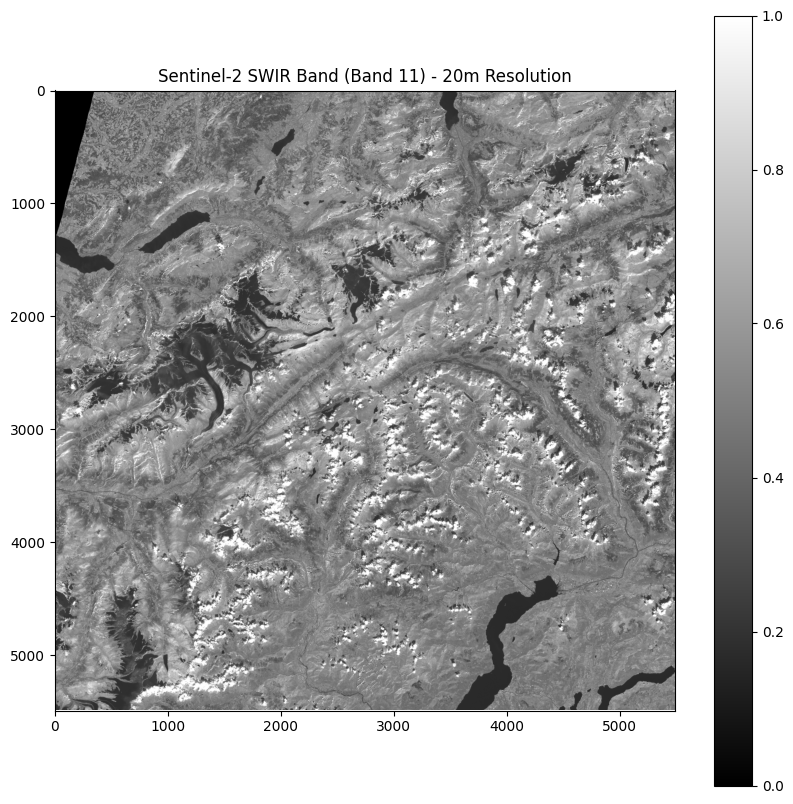

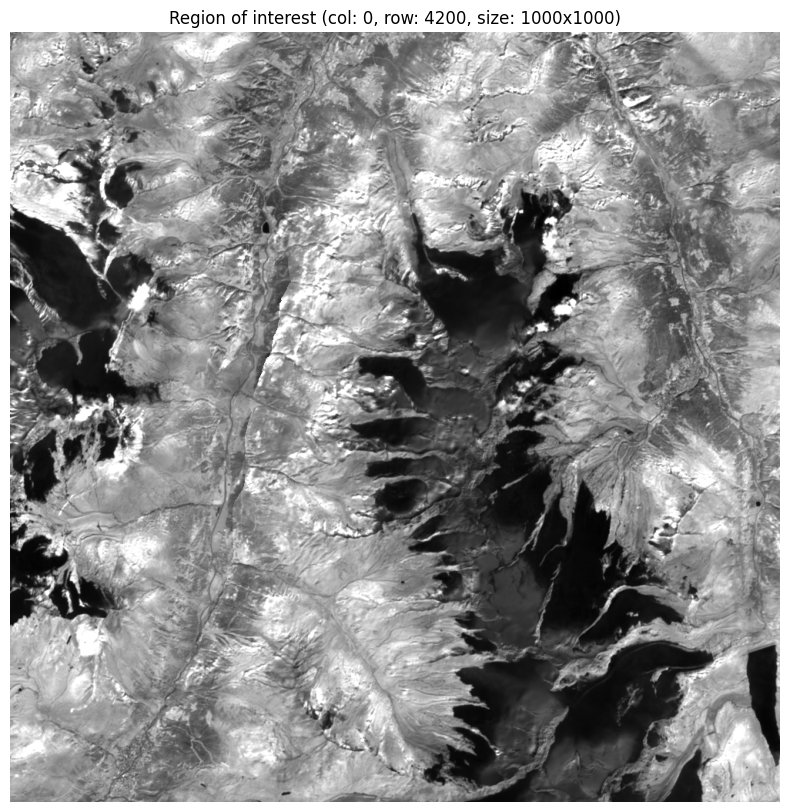

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to SWIR band (Band 11 is at 20m resolution)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2" # SWIR (Band 11)

# Open and read the image (SWIR band only)
with rasterio.open(band_swir_path) as src:
    band_swir = src.read(1)
    transform = src.transform

# Normalize SWIR values for visualization
band_swir_clipped = np.clip(band_swir, 0, np.percentile(band_swir, 98))
band_swir_normalized = band_swir_clipped / np.max(band_swir_clipped)

# Plot the SWIR image
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(band_swir_normalized, cmap='gray')
ax.set_title("Sentinel-2 SWIR Band (Band 11) - 20m Resolution")
plt.colorbar(cax)
plt.show()

# Define a region of interest manually
col_off = 0
row_off = 4200
width = 1000
height = 1000

# Extract windowed region
window = rasterio.windows.Window(col_off, row_off, width, height)

# Read the selected region
with rasterio.open(band_swir_path) as src:
    band_swir_region = src.read(1, window=window)

# Normalize the selected region
band_swir_region_clipped = np.clip(band_swir_region, 0, np.percentile(band_swir_region, 98))
band_swir_region_normalized = band_swir_region_clipped / np.max(band_swir_region_clipped)

# Plot the cropped SWIR image
plt.figure(figsize=(10, 10))
plt.imshow(band_swir_region_normalized, cmap='gray')
plt.axis("off")
plt.title(f"Region of interest (col: {col_off}, row: {row_off}, size: {width}x{height})")
plt.show()


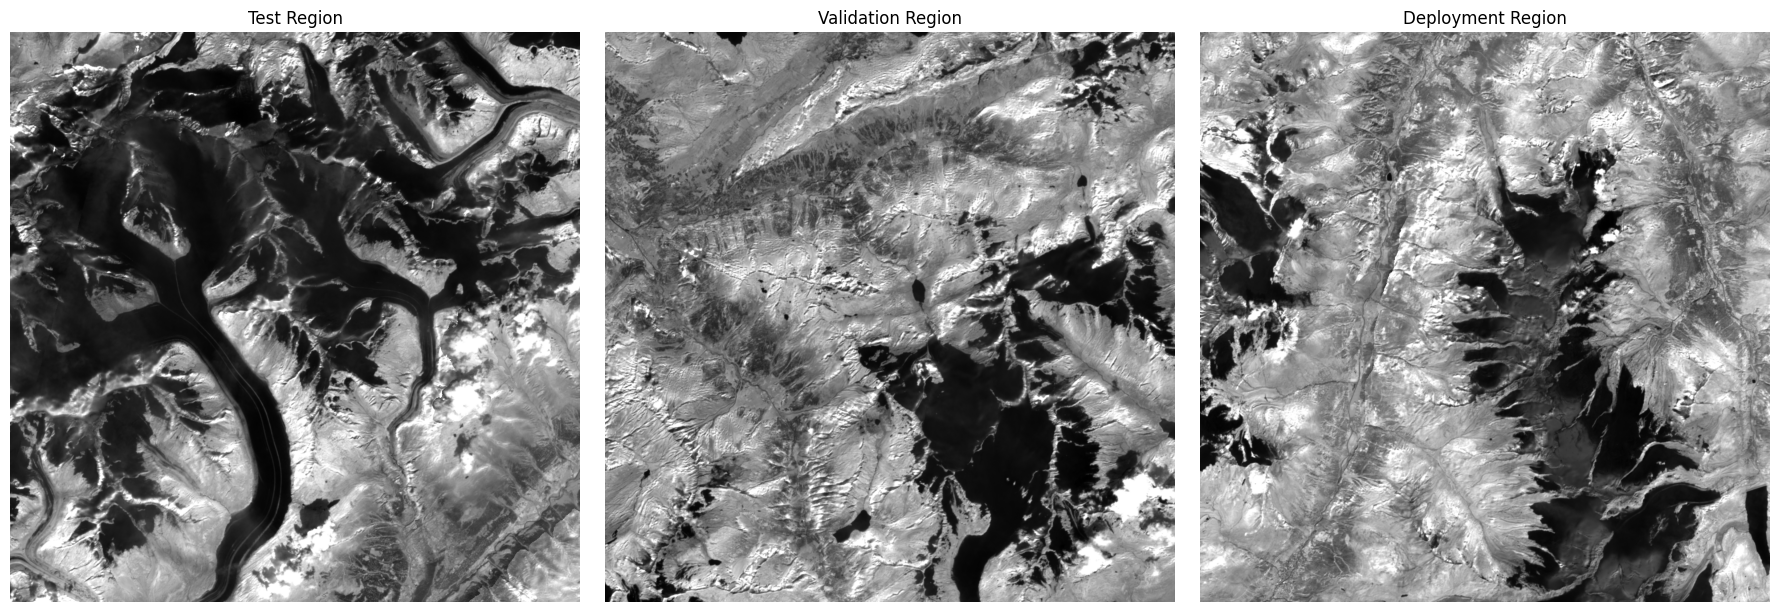

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to SWIR band (Band 11)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"

# Define the three regions of interest
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# Open the raster file once
with rasterio.open(band_swir_path) as src:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (title, params) in zip(axes, regions.items()):
        window = rasterio.windows.Window(**params)
        region_data = src.read(1, window=window)

        # Normalize the data
        region_clipped = np.clip(region_data, 0, np.percentile(region_data, 98))
        region_normalized = region_clipped / np.max(region_clipped)

        # Plot
        cax = ax.imshow(region_normalized, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    #plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/area_of_interest.png", dpi=300, bbox_inches='tight')
    plt.show()


# Normalized Difference Snow Index (NDSI)

The code cell below will calculate the NDSI index using the Green band (band 3) and SWIR band (Band 11). For the complete equation, please refer to the project GitHub page.

<ipython-input-11-b99ea7da894f>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


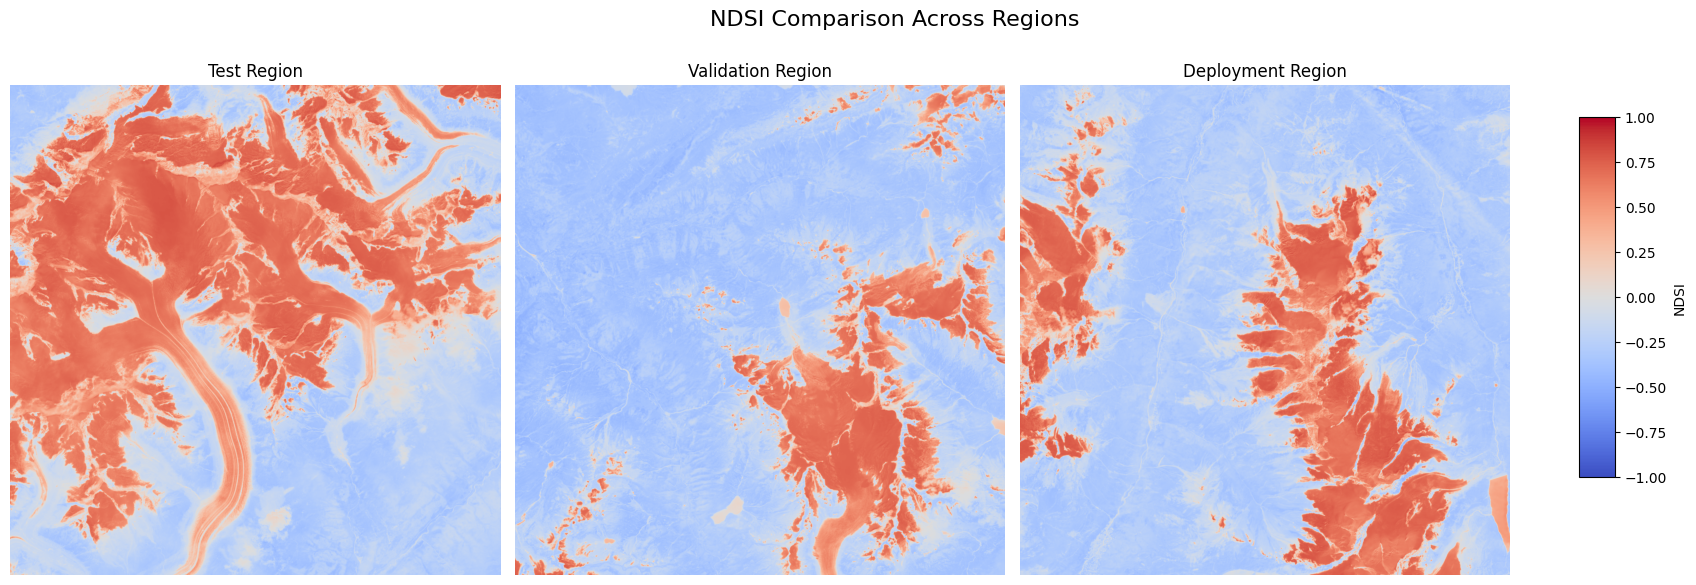

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Set the file paths for the Green (Band 3) and SWIR (Band 11) bands
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"  # Green (Band 3)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (Band 11)

# Define the three regions
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# Prepare the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop over each region and calculate/display NDSI
for ax, (title, params) in zip(axes, regions.items()):
    window = rasterio.windows.Window(**params)

    # Read bands
    with rasterio.open(band_green_path) as green_src:
        green_band = green_src.read(1, window=window)
    with rasterio.open(band_swir_path) as swir_src:
        swir_band = swir_src.read(1, window=window)

    # Normalize bands
    green_norm = green_band / np.max(green_band)
    swir_norm = swir_band / np.max(swir_band)

    # Compute NDSI
    denominator = green_norm + swir_norm
    denominator[denominator == 0] = np.nan  # Avoid division by zero
    ndsi = (green_norm - swir_norm) / denominator

    # Plot
    cax = ax.imshow(ndsi, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.6])
fig.colorbar(cax, cax=cbar_ax, label="NDSI")

plt.suptitle("NDSI Comparison Across Regions", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/NDSI_calculation.png", dpi=300, bbox_inches='tight')
plt.show()


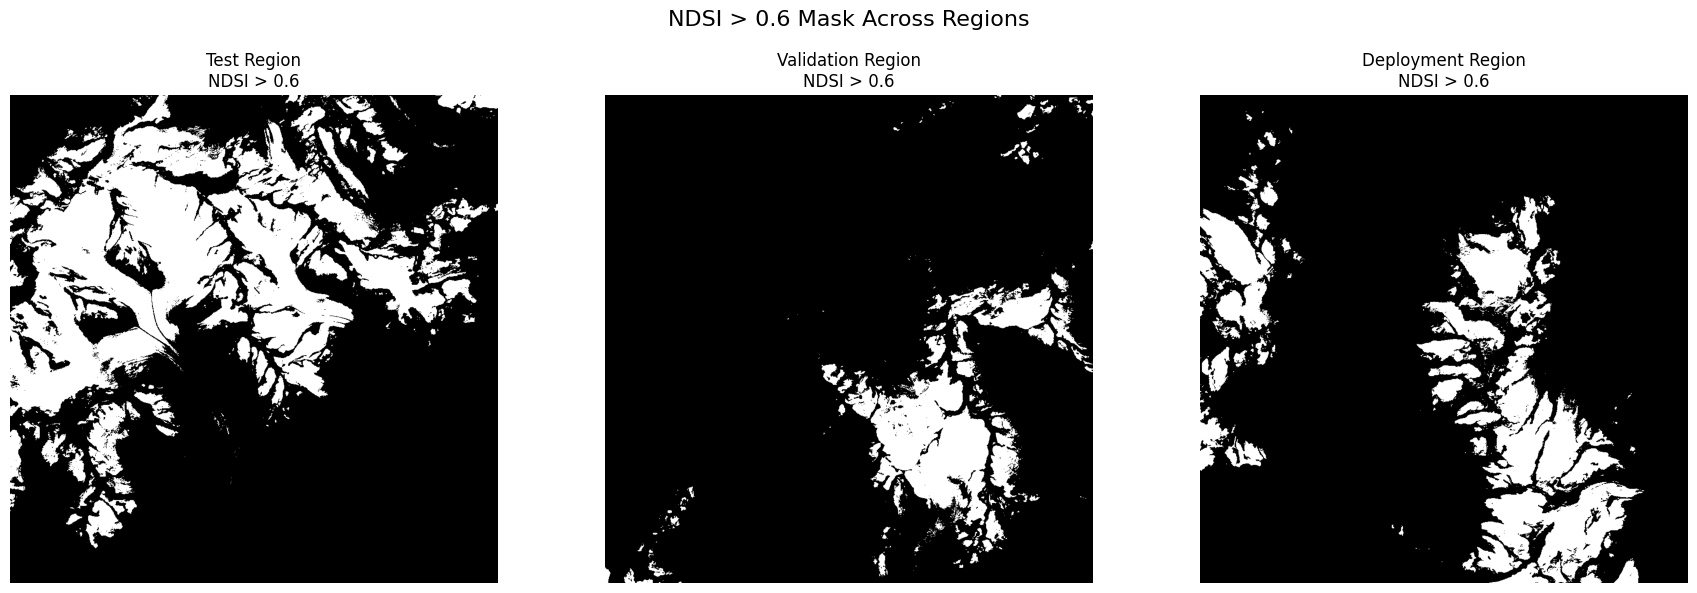

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Set the file paths for the Green (Band 3) and SWIR (Band 11) bands
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"  # Green (Band 3)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (Band 11)

# Define the three regions
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# Prepare the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))



# Loop over each region and calculate/display NDSI mask with threshold
for ax, (title, params) in zip(axes, regions.items()):
    window = rasterio.windows.Window(**params)

    # Read bands
    with rasterio.open(band_green_path) as green_src:
        green_band = green_src.read(1, window=window)
    with rasterio.open(band_swir_path) as swir_src:
        swir_band = swir_src.read(1, window=window)

    # Normalize bands
    green_norm = green_band / np.max(green_band)
    swir_norm = swir_band / np.max(swir_band)

    # Compute NDSI
    denominator = green_norm + swir_norm
    denominator[denominator == 0] = np.nan  # Avoid division by zero
    ndsi = (green_norm - swir_norm) / denominator

    # Create binary mask for NDSI > 0.6
    ndsi_mask = ndsi > 0.6

    # Plot binary mask
    ax.imshow(ndsi_mask, cmap='gray')
    ax.set_title(f"{title}\nNDSI > 0.6")
    ax.axis('off')

plt.suptitle("NDSI > 0.6 Mask Across Regions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The code cell below will calculate the NDSII index using the NIR band (band 8A) and the SWIR band (Band 11). For the complete equation, please refer to the project GitHub page.

<ipython-input-12-f81af693e45a>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


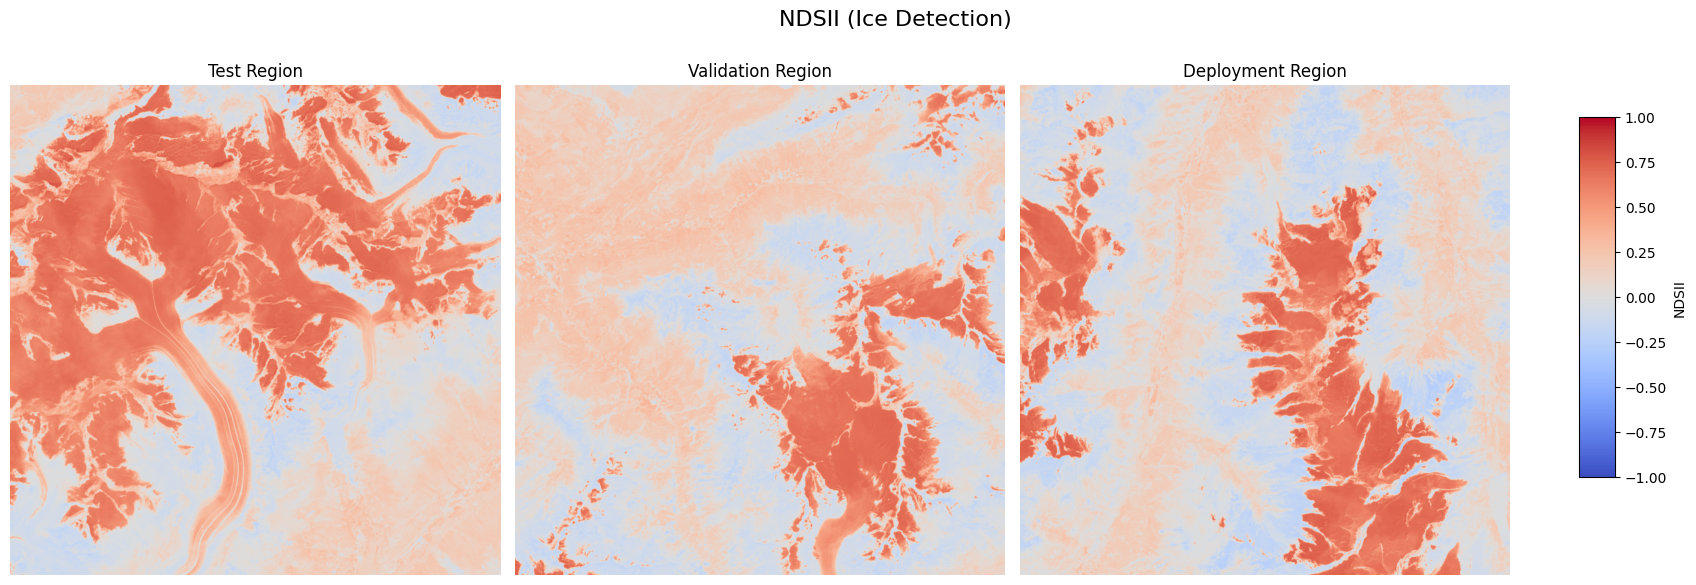

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths
band_nir_path_20m = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"
band_swir_path_20m = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"

# Regions at 20m scale
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, params) in zip(axes, regions.items()):
    window = rasterio.windows.Window(**params)

    # Read SWIR at 20m
    with rasterio.open(band_swir_path_20m) as swir_src:
        swir_band = swir_src.read(1, window=window)

    # Read NIR (Band 8A) at 20m
    with rasterio.open(band_nir_path_20m) as nir_src:
        nir_band = nir_src.read(1, window=window)

    # Normalize
    nir_norm = nir_band / np.max(nir_band)
    swir_norm = swir_band / np.max(swir_band)

    # Compute NDSII
    denominator = nir_norm + swir_norm
    denominator[denominator == 0] = np.nan
    ndsii = (nir_norm - swir_norm) / denominator

    # Plot
    cax = ax.imshow(ndsii, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.6])
fig.colorbar(cax, cax=cbar_ax, label="NDSII")

plt.suptitle("NDSII (Ice Detection)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/NDSII_calculation.png", dpi=300, bbox_inches='tight')
plt.show()


The code cell below will combine the two indices calculated above to create a mask for the three regions. The threshold is set as: glacier_mask = (ndsi > 0.4) & (ndsii > 0.3).

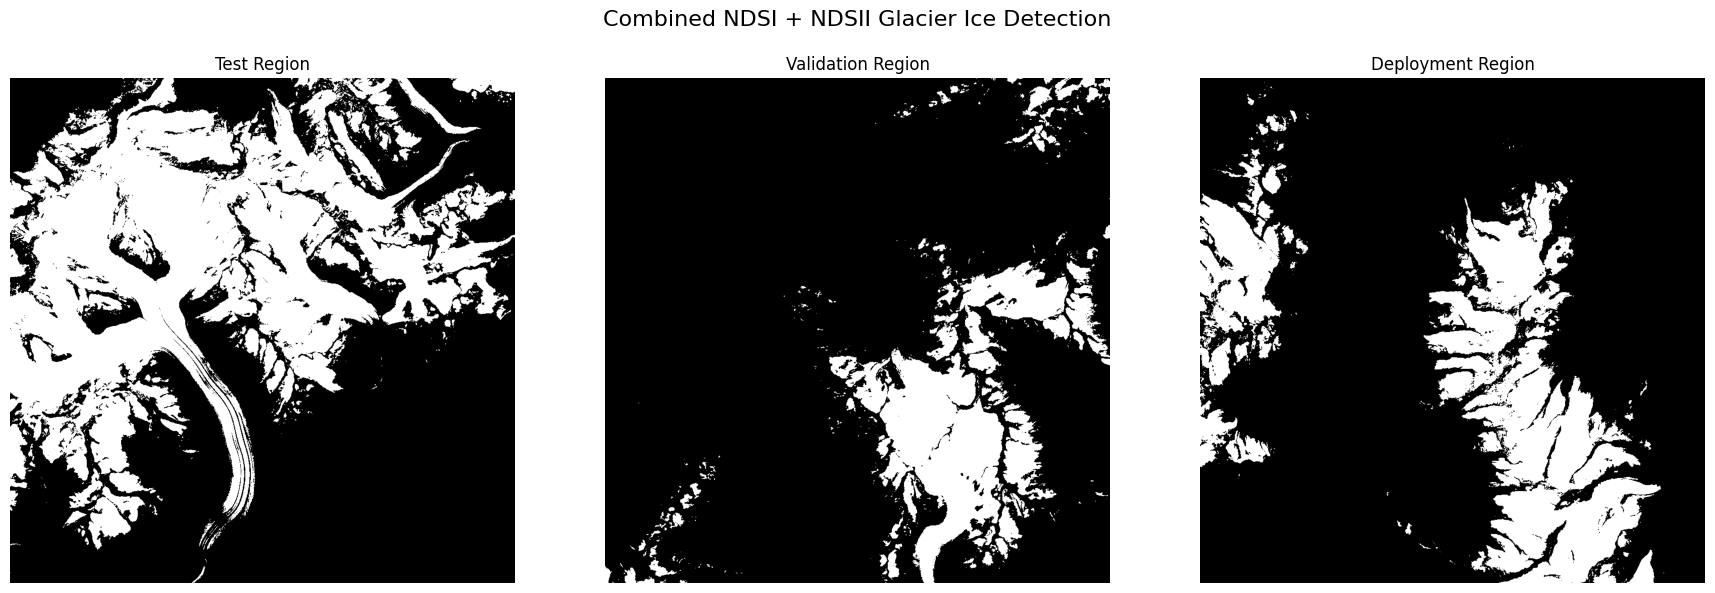

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File paths
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"  # Green (20m)
band_swir_path =  "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (20m)
band_nir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"  # NIR 8A (20m)

# Define regions
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, params) in zip(axes, regions.items()):
    window = rasterio.windows.Window(**params)

    # Read Green band
    with rasterio.open(band_green_path) as green_src:
        green_band = green_src.read(1, window=window)

    # Read SWIR band
    with rasterio.open(band_swir_path) as swir_src:
        swir_band = swir_src.read(1, window=window)

    # Read NIR 8A band (already at 20m)
    with rasterio.open(band_nir_path) as nir_src:
        nir_band = nir_src.read(1, window=window)

    # Normalize bands
    green_norm = green_band / np.max(green_band)
    swir_norm = swir_band / np.max(swir_band)
    nir_norm = nir_band / np.max(nir_band)

    # Compute indices
    ndsi = (green_norm - swir_norm) / (green_norm + swir_norm + 1e-6)
    ndsii = (nir_norm - swir_norm) / (nir_norm + swir_norm + 1e-6)

    # Combined glacier mask
    glacier_mask = (ndsi > 0.4) & (ndsii > 0.3)

    # Plot
    ax.imshow(glacier_mask, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Show
plt.suptitle("Combined NDSI + NDSII Glacier Ice Detection", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the suptitle
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/NDSI_NDSII_mask.png", dpi=300, bbox_inches='tight')
plt.show()


The code cell below will save the three masks created above.

In [ ]:
import rasterio
import numpy as np
import os

# Set the file paths for Sentinel-2 bands (all at 20m)
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"  # Green (Band 3, 20m)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (Band 11, 20m)
band_nir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"  # NIR narrow (Band 8A, 20m)

# Define the three regions
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# Output directory for masks
output_dir = "/content/drive/MyDrive/GEOL0069_data/Final Project/"
os.makedirs(output_dir, exist_ok=True)

# Loop over regions and save glacier masks
for title, params in regions.items():
    window = rasterio.windows.Window(**params)

    # Read 20m bands
    with rasterio.open(band_green_path) as green_src:
        green_band = green_src.read(1, window=window)
    with rasterio.open(band_swir_path) as swir_src:
        swir_band = swir_src.read(1, window=window)
    with rasterio.open(band_nir_path) as nir_src:
        nir_band = nir_src.read(1, window=window)

    # Normalize bands
    green_norm = green_band / np.max(green_band)
    swir_norm = swir_band / np.max(swir_band)
    nir_norm = nir_band / np.max(nir_band)

    # Calculate indices
    ndsi = (green_norm - swir_norm) / (green_norm + swir_norm + 1e-6)
    ndsii = (nir_norm - swir_norm) / (nir_norm + swir_norm + 1e-6)

    # Glacier mask
    glacier_mask = (ndsi > 0.4) & (ndsii > 0.3)

    # Save mask
    output_path = os.path.join(output_dir, f"{title.replace(' ', '_')}_glacier_mask.npy")
    np.save(output_path, glacier_mask.astype(np.uint8))
    print(f"Saved: {output_path}")


Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Test_Region_glacier_mask.npy
Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Validation_Region_glacier_mask.npy
Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Deployment_Region_glacier_mask.npy


# K-means

K-means classification is an unsupervised machine learning tool that doesn't require labelled data. It will compare neighbouring pixels to find trends, patterns and similarity. The initialisation, location, and parameters of the centroids used in the model can be changed to meet the user's needs. The model can be adjusted to change the number of clusters or groups to be identified. In this project, this method was used as a baseline classifier to find ice-covered areas.

Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Test_Region_kmeans_mask.npy
Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Validation_Region_kmeans_mask.npy
Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Deployment_Region_kmeans_mask.npy


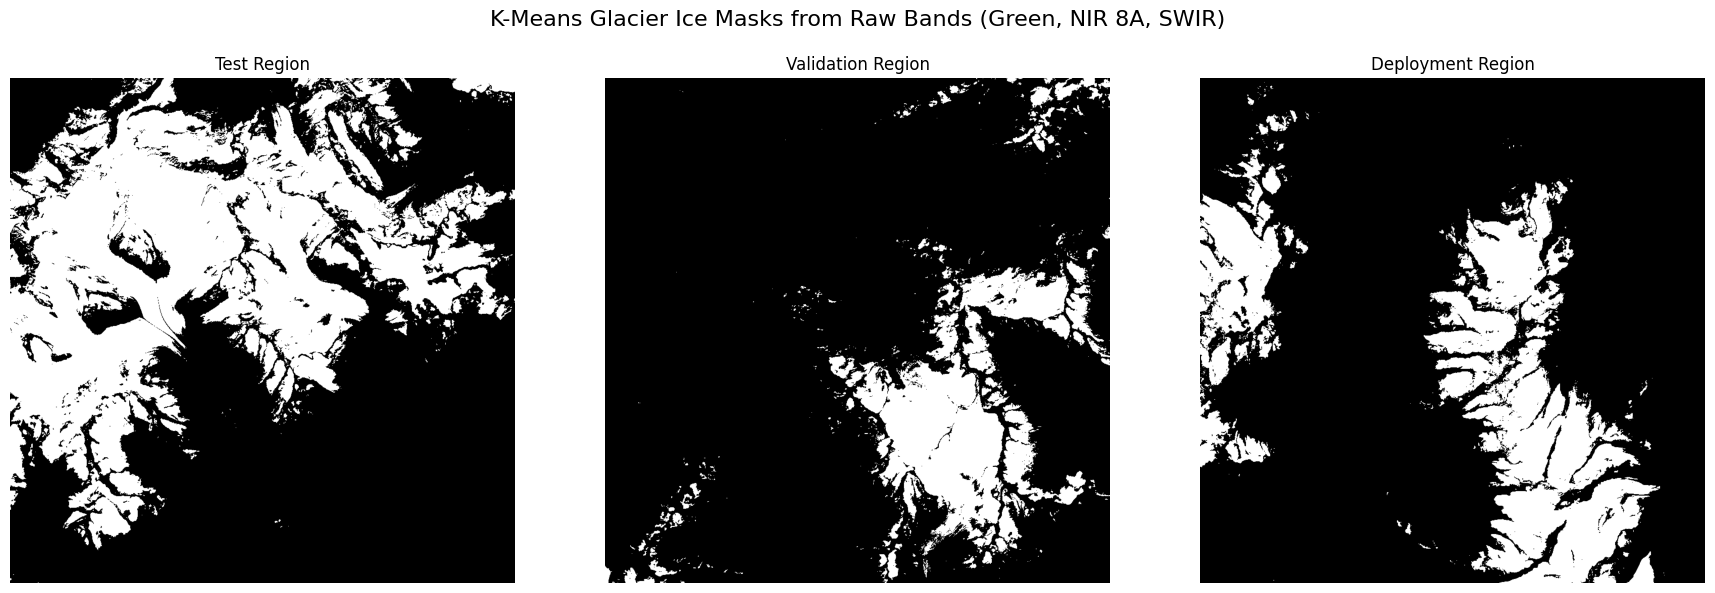

In [ ]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ---------- INPUT PATHS ----------
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"  # Green (Band 3, 20m)
band_swir_path  = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"  # SWIR (Band 11, 20m)
band_nir_path   = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"  # Narrow NIR (Band 8A, 20m)

# ---------- REGIONS ----------
regions = {
    "Test Region": {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000},
    "Validation Region": {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000},
    "Deployment Region": {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
}

# ---------- OUTPUT ----------
out_dir = "/content/drive/MyDrive/GEOL0069_data/Final Project/"
os.makedirs(out_dir, exist_ok=True)

# ---------- PREPARE DISPLAY ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("K-Means Glacier Ice Masks from Raw Bands (Green, NIR 8A, SWIR)", fontsize=16)

# ---------- PROCESS EACH REGION ----------
for ax, (title, win) in zip(axes, regions.items()):
    window = rasterio.windows.Window(**win)

    with rasterio.open(band_green_path) as gsrc:
        green = gsrc.read(1, window=window).astype("float32")
    with rasterio.open(band_swir_path) as ssrc:
        swir = ssrc.read(1, window=window).astype("float32")
    with rasterio.open(band_nir_path) as nsrc:
        nir = nsrc.read(1, window=window).astype("float32")

    # Stack raw bands
    X = np.stack([green.ravel(), nir.ravel(), swir.ravel()], axis=1)
    valid = ~np.isnan(X).any(axis=1)
    X_valid = X[valid]

    # K-means clustering
    scaler = StandardScaler().fit(X_valid)
    X_scaled = scaler.transform(X_valid)
    km = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(X_scaled)

    labels = np.full(X.shape[0], -1, dtype=int)
    labels[valid] = km.labels_

    # Identify ice cluster by lower SWIR reflectance
    means = [np.nanmean(swir.ravel()[labels == k]) for k in (0, 1)]
    ice_cluster = int(np.argmin(means))

    # Build mask
    mask = (labels.reshape(green.shape) == ice_cluster).astype(np.uint8)
    mask[~np.isfinite(green)] = 0

    # Save mask
    out_path = os.path.join(out_dir, f"{title.replace(' ', '_')}_kmeans_mask.npy")
    np.save(out_path, mask)
    print(f"Saved: {out_path}")

    # Display
    ax.imshow(mask, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/K_means_mask.png", dpi=300, bbox_inches='tight')
plt.show()


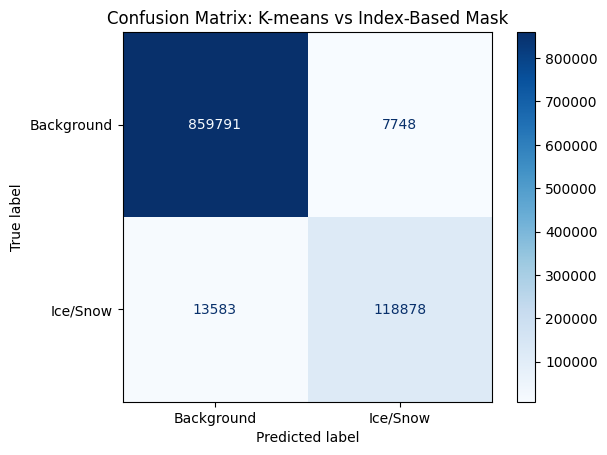

Precision: 0.94
Recall:    0.90
F1 Score:  0.92


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Load your masks ---
index_mask_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/Validation_Region_glacier_mask.npy"
kmeans_mask_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/Validation_Region_kmeans_mask.npy"

index_mask = np.load(index_mask_path).astype(np.uint8).ravel()
kmeans_mask = np.load(kmeans_mask_path).astype(np.uint8).ravel()

# --- Filter out invalid pixels (e.g., nodata areas) ---
valid = np.isin(index_mask, [0, 1]) & np.isin(kmeans_mask, [0, 1])
index_mask_valid = index_mask[valid]
kmeans_mask_valid = kmeans_mask[valid]

# --- Compute confusion matrix ---
labels = [0, 1]  # 0 = background, 1 = snow/ice
cm = confusion_matrix(index_mask_valid, kmeans_mask_valid, labels=labels)

# --- Display confusion matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Ice/Snow"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: K-means vs Index-Based Mask")
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/K_means_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print precision, recall, etc.
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


#CNN model


Convolutional Neural Networks (CNNs) are a type of supervised machine learning model that are trained using labelled datasets. In this project, a CNN model will be trained using labelled data derived from benchmark indices alongside Sentinal-2 optical bands.

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9580 - loss: 0.1442 - val_accuracy: 0.9937 - val_loss: 0.0166
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9959 - loss: 0.0128 - val_accuracy: 0.9980 - val_loss: 0.0077
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9979 - loss: 0.0073 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9989 - val_loss: 0.0041
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9983 - loss: 0.0047 - val_accuracy: 0.9988 - val_loss: 0.0039
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9986 - val_loss: 0.0040
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9984 - loss: 0.

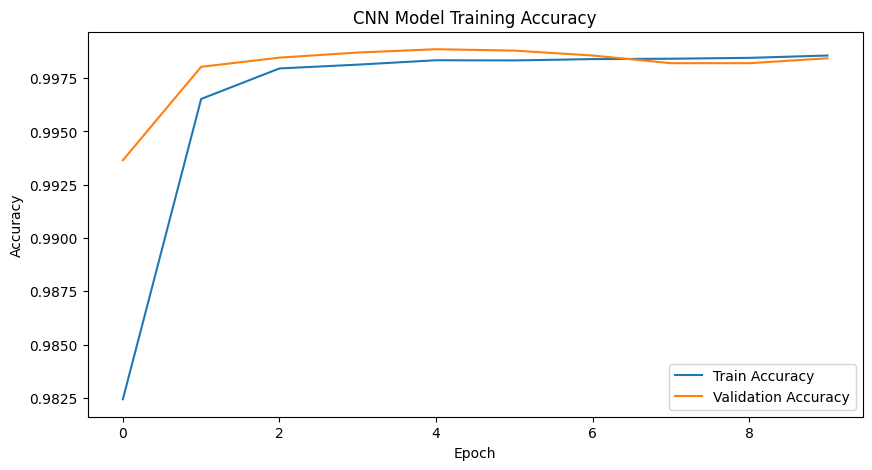

In [ ]:
import rasterio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# file paths
band_nir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"
band_red_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B04_20m.jp2"
band_blue_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B02_20m.jp2"

# Test region
test_region = {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000}
window_20m = rasterio.windows.Window(**test_region)

# Read 20m bands
def read_band(path, window):
    with rasterio.open(path) as src:
        return src.read(1, window=window).astype(np.float32)

# Normalize
def normalize_band(band):
    return band / np.max(band)

# Read and normalize all bands (all are 20m resolution)
green_band = normalize_band(read_band(band_green_path, window_20m))
swir_band  = normalize_band(read_band(band_swir_path,  window_20m))
red_band   = normalize_band(read_band(band_red_path,   window_20m))
blue_band  = normalize_band(read_band(band_blue_path,  window_20m))
nir_band   = normalize_band(read_band(band_nir_path,   window_20m))

# Stack all bands into (H, W, 5)
data = np.stack((green_band, swir_band, red_band, blue_band, nir_band), axis=-1)

# Load mask
mask_path = '/content/drive/MyDrive/GEOL0069_data/Final Project/Test_Region_glacier_mask.npy'
mask_snow = np.load(mask_path)

# Flatten data and labels
X = data.reshape(-1, 5)
y = mask_snow.reshape(-1).astype(np.uint8)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input
X_train = X_train.reshape(-1, 1, 1, 5)
X_val = X_val.reshape(-1, 1, 1, 5)

# One-hot encode
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

# Define CNN
model = models.Sequential([
    layers.Input(shape=(1, 1, 5)),
    layers.Conv2D(16, (1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256)

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Training Accuracy')
plt.legend()
plt.show()

# Save model
#model.save("/content/drive/MyDrive/GEOL0069_data/Final Project/glacier_ice_cnn_model.h5")


The code cell below will load the CNN model compiled above and roll it out on the validation region.

977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


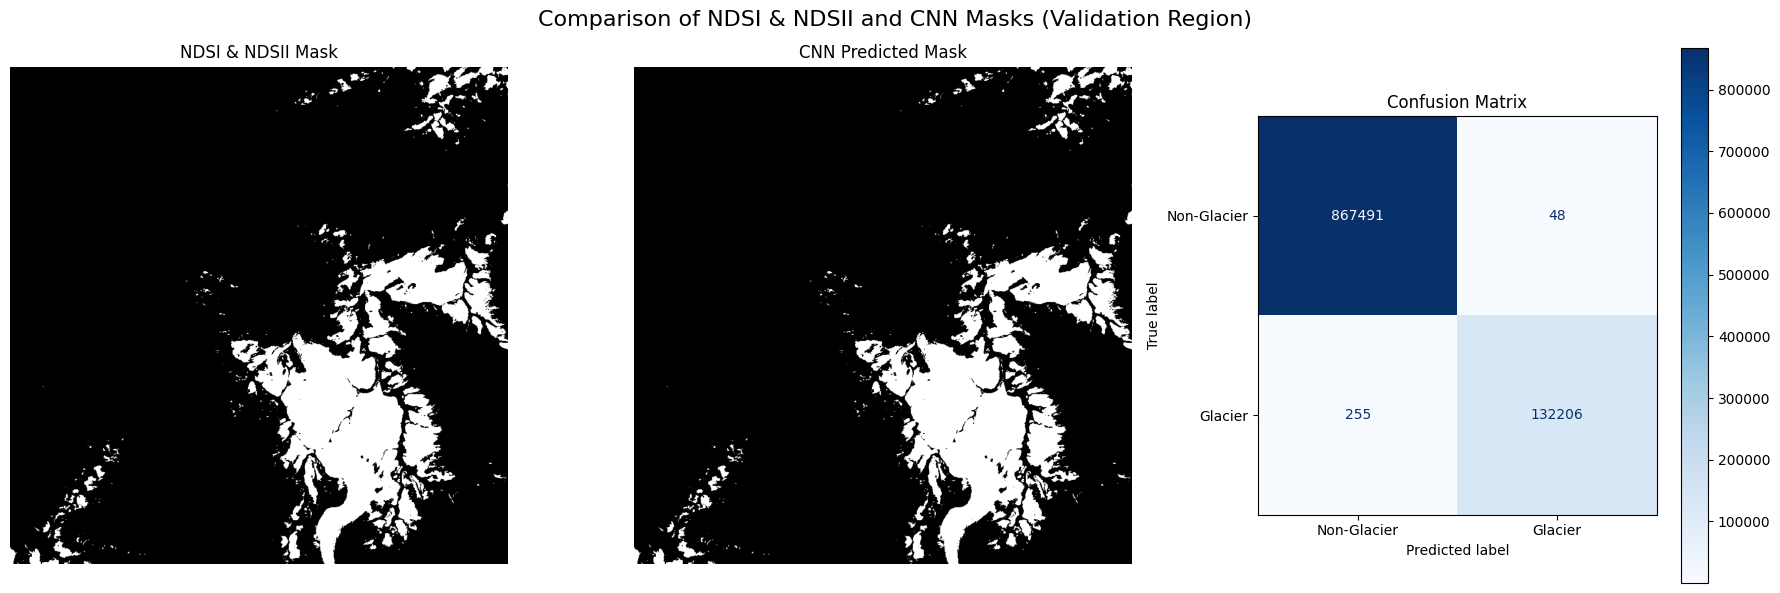

Precision: 1.00
Recall:    1.00
F1 Score:  1.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Paths to the model and bands
model_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/glacier_ice_cnn_model.h5"
band_paths = {
    "green": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2",
    "swir": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2",
    "red": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B04_20m.jp2",
    "blue": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B02_20m.jp2",
    "nir": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2",
}

# Validation region window
val_region = {"col_off": 2000, "row_off": 1000, "width": 1000, "height": 1000}
window_20m = rasterio.windows.Window(**val_region)

# Read and normalize bands at 20m resolution
def read_and_normalize(path, window):
    with rasterio.open(path) as src:
        band = src.read(1, window=window).astype(np.float32)
        return band / np.max(band)

# Read all bands
bands = [
    read_and_normalize(band_paths["green"], window_20m),
    read_and_normalize(band_paths["swir"], window_20m),
    read_and_normalize(band_paths["red"], window_20m),
    read_and_normalize(band_paths["blue"], window_20m),
    read_and_normalize(band_paths["nir"], window_20m)
]

data_val = np.stack(bands, axis=-1)  # Shape: (height, width, 5)

# Flatten and reshape for CNN input
height, width, _ = data_val.shape
data_val_flat = data_val.reshape(-1, 5).astype(np.float32)
data_val_input = data_val_flat.reshape(-1, 1, 1, 5)

# Load CNN model
model = load_model(model_path)

# Predict on validation region
y_pred = model.predict(data_val_input, batch_size=1024)
y_pred_labels = np.argmax(y_pred, axis=-1)
cnn_mask = y_pred_labels.reshape(height, width)

# Load index-based (NDSI) mask
ndsi_mask_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/Validation_Region_glacier_mask.npy"
ndsi_mask = np.load(ndsi_mask_path)

# Flatten both masks for confusion matrix
cnn_flat = cnn_mask.flatten()
ndsi_flat = ndsi_mask.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndsi_flat, cnn_flat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Glacier", "Glacier"])

# Plot side-by-side masks and confusion matrix
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(ndsi_mask, cmap='gray')
plt.title('NDSI & NDSII Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cnn_mask, cmap='gray')
plt.title('CNN Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

plt.suptitle("Comparison of NDSI & NDSII and CNN Masks (Validation Region)", fontsize=16)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_validation_region.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print precision, recall, etc.
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


The code cell below will load the CNN model compiled above and roll it out on the deployment region.

977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


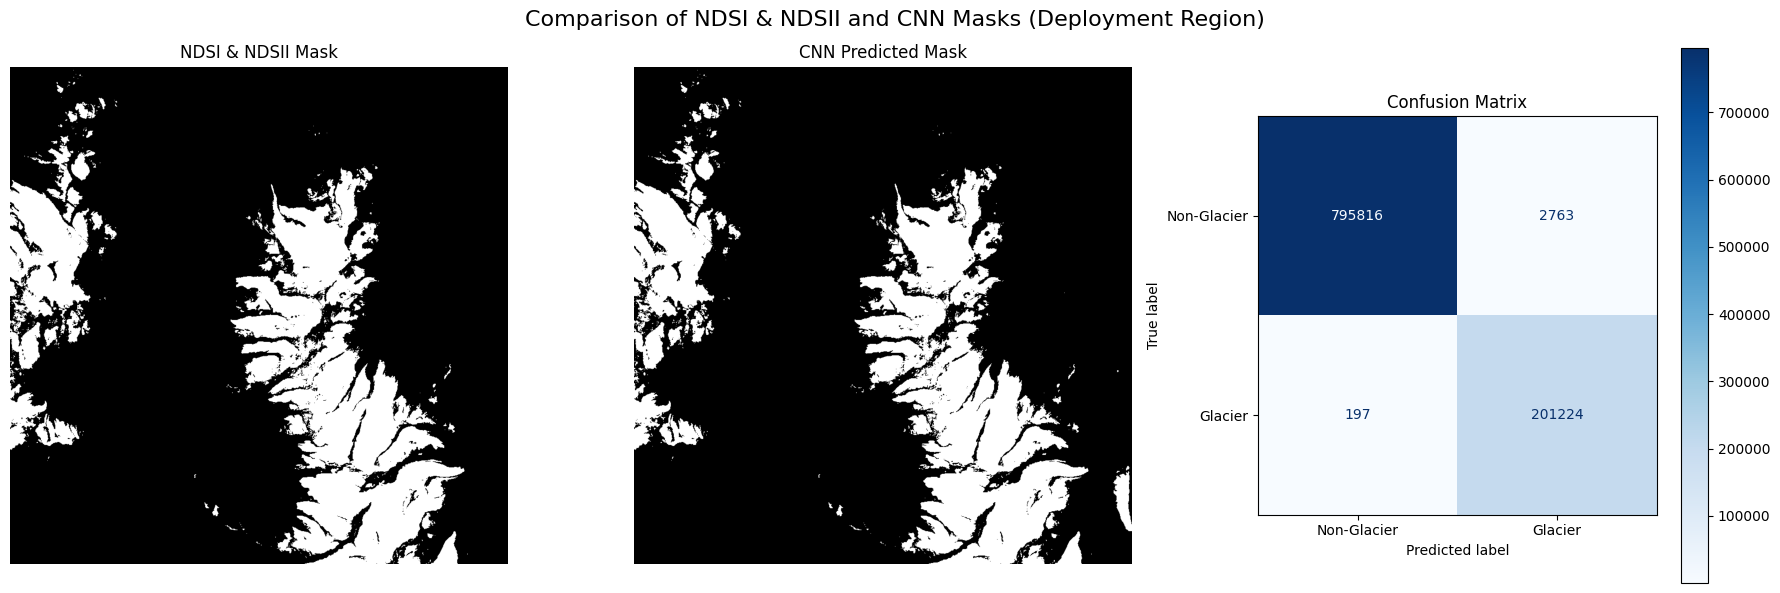

Precision: 0.99
Recall:    1.00
F1 Score:  0.99


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths to the model and bands
model_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/glacier_ice_cnn_model.h5"
band_paths = {
    "green": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2",
    "swir": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2",
    "red": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B04_20m.jp2",
    "blue": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B02_20m.jp2",
    "nir": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2",
}

# Deployment region window
deployment_region = {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
window_20m = rasterio.windows.Window(**deployment_region)

# Read and normalize bands at 20m resolution
def read_and_normalize(path, window):
    with rasterio.open(path) as src:
        band = src.read(1, window=window).astype(np.float32)
        return band / np.max(band)

# Read all bands (5-band input)
bands = [
    read_and_normalize(band_paths["green"], window_20m),
    read_and_normalize(band_paths["swir"], window_20m),
    read_and_normalize(band_paths["red"], window_20m),
    read_and_normalize(band_paths["blue"], window_20m),
    read_and_normalize(band_paths["nir"], window_20m)
]

data_val = np.stack(bands, axis=-1)  # Shape: (height, width, 5)

# Flatten and reshape for CNN input
height, width, _ = data_val.shape
data_val_flat = data_val.reshape(-1, 5).astype(np.float32)
data_val_input = data_val_flat.reshape(-1, 1, 1, 5)

# Load CNN model
model = load_model(model_path)

# Predict on validation region
y_pred = model.predict(data_val_input, batch_size=1024)
y_pred_labels = np.argmax(y_pred, axis=-1)
cnn_mask = y_pred_labels.reshape(height, width)

# Load index-based (NDSI) mask
ndsi_mask_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/Deployment_Region_glacier_mask.npy"
ndsi_mask = np.load(ndsi_mask_path)

# Flatten both masks for confusion matrix
cnn_flat = cnn_mask.flatten()
ndsi_flat = ndsi_mask.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndsi_flat, cnn_flat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Glacier", "Glacier"])

# Plot side-by-side masks and confusion matrix
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(ndsi_mask, cmap='gray')
plt.title('NDSI & NDSII Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cnn_mask, cmap='gray')
plt.title('CNN Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

plt.suptitle("Comparison of NDSI & NDSII and CNN Masks (Deployment Region)", fontsize=16)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region.png", dpi=300, bbox_inches='tight')
plt.show()

# Save CNN predicted mask as .npy file
#np.save("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region_mask_2017.npy", cnn_mask)


# Optional: Print precision, recall, etc.
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


# Deployment on 2023 data

Firstly, the code cell below creates a mask from the deployment of the CNN model on the 2023 data (deployment region).

In [ ]:
import rasterio
import numpy as np
import os

# Set the file paths for Sentinel-2 bands (all at 20m)
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B03_20m.jp2"  # Green (Band 3, 20m)
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B11_20m.jp2"  # SWIR (Band 11, 20m)
band_nir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B8A_20m.jp2"  # NIR narrow (Band 8A, 20m)

# Deployment region only
deployment_region = {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
window = rasterio.windows.Window(**deployment_region)

# Output directory
output_dir = "/content/drive/MyDrive/GEOL0069_data/Final Project/"
os.makedirs(output_dir, exist_ok=True)

# Read bands
with rasterio.open(band_green_path) as green_src:
    green_band = green_src.read(1, window=window)
with rasterio.open(band_swir_path) as swir_src:
    swir_band = swir_src.read(1, window=window)
with rasterio.open(band_nir_path) as nir_src:
    nir_band = nir_src.read(1, window=window)

# Normalize bands
green_norm = green_band / np.max(green_band)
swir_norm = swir_band / np.max(swir_band)
nir_norm = nir_band / np.max(nir_band)

# Calculate indices
ndsi = (green_norm - swir_norm) / (green_norm + swir_norm + 1e-6)
ndsii = (nir_norm - swir_norm) / (nir_norm + swir_norm + 1e-6)

# Glacier mask
glacier_mask = (ndsi > 0.4) & (ndsii > 0.3)

# Save mask
output_path = os.path.join(output_dir, "Deployment_Region_glacier_mask_2023.npy")
np.save(output_path, glacier_mask.astype(np.uint8))
print(f"Saved: {output_path}")


Saved: /content/drive/MyDrive/GEOL0069_data/Final Project/Deployment_Region_glacier_mask_2023.npy


The code cell below will load the CNN model compiled above and roll it out on the deployment region. for the 2023 satellite data.

977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


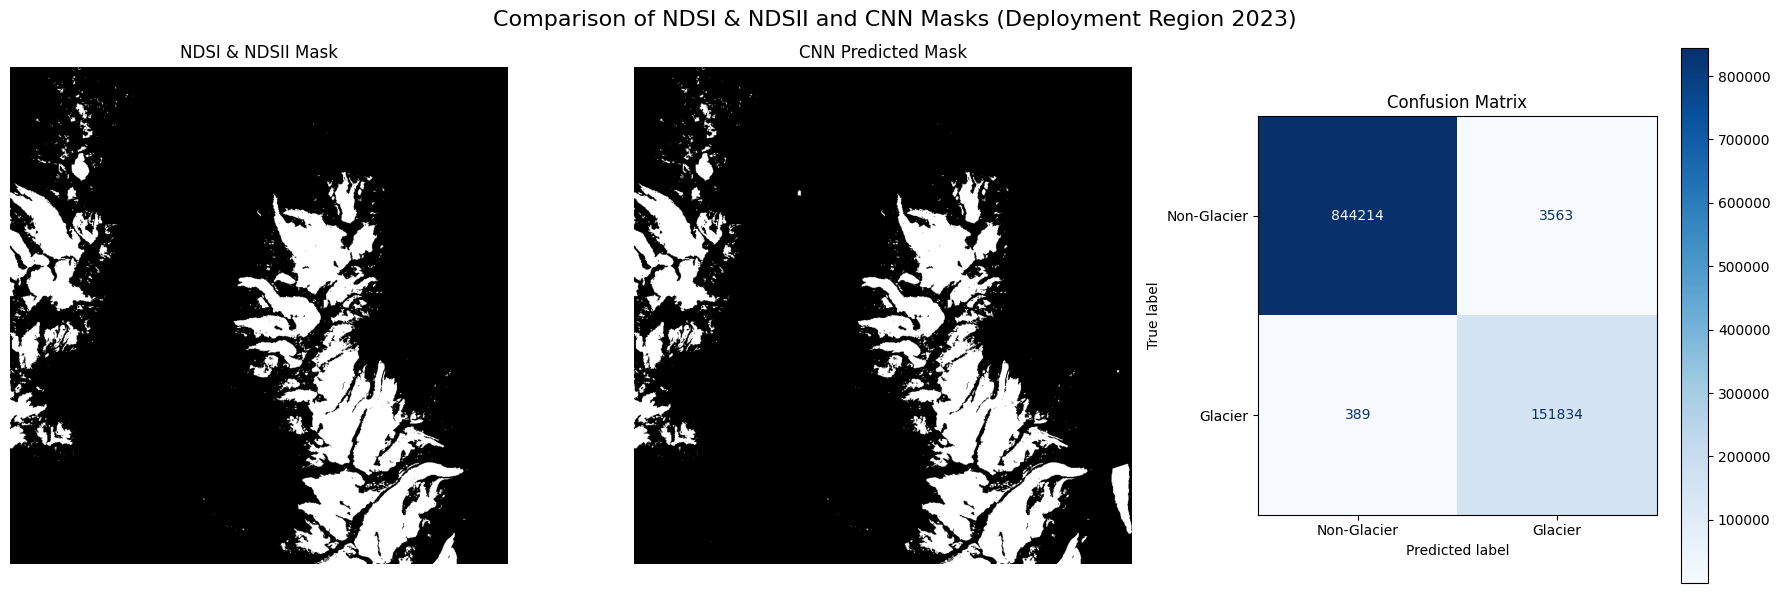

Precision: 0.98
Recall:    1.00
F1 Score:  0.99


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths to the model and bands
model_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/glacier_ice_cnn_model.h5"
band_paths = {
    "green": "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B03_20m.jp2",
    "swir":  "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B11_20m.jp2",
    "red":   "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B04_20m.jp2",
    "blue":  "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B02_20m.jp2",
    "nirn":  "/content/drive/MyDrive/GEOL0069_data/Final Project/S2B_MSIL2A_20230720T101609_N0509_R065_T32TMS_20230720T131906.SAFE/GRANULE/L2A_T32TMS_A033267_20230720T102132/IMG_DATA/R20m/T32TMS_20230720T101609_B8A_20m.jp2",
}

# Deployment region window
deployment_region = {"col_off": 0, "row_off": 4200, "width": 1000, "height": 1000}
window_20m = rasterio.windows.Window(**deployment_region)

# Read and normalize bands at 20m resolution
def read_and_normalize(path, window):
    with rasterio.open(path) as src:
        band = src.read(1, window=window).astype(np.float32)
        return band / np.max(band)

# Read all bands (5-band input)
bands = [
    read_and_normalize(band_paths["green"], window_20m),
    read_and_normalize(band_paths["swir"], window_20m),
    read_and_normalize(band_paths["red"], window_20m),
    read_and_normalize(band_paths["blue"], window_20m),
    read_and_normalize(band_paths["nirn"], window_20m)  # Band 8A (NIR Narrow) at 20m
]

data_val = np.stack(bands, axis=-1)  # Shape: (height, width, 5)

# Flatten and reshape for CNN input
height, width, _ = data_val.shape
data_val_flat = data_val.reshape(-1, 5).astype(np.float32)
data_val_input = data_val_flat.reshape(-1, 1, 1, 5)

# Load CNN model
model = load_model(model_path)

# Predict on validation region
y_pred = model.predict(data_val_input, batch_size=1024)
y_pred_labels = np.argmax(y_pred, axis=-1)
cnn_mask = y_pred_labels.reshape(height, width)

# Load index-based (NDSI) mask
ndsi_mask_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/Deployment_Region_glacier_mask_2023.npy"
ndsi_mask = np.load(ndsi_mask_path)

# Flatten both masks for confusion matrix
cnn_flat = cnn_mask.flatten()
ndsi_flat = ndsi_mask.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndsi_flat, cnn_flat, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Glacier", "Glacier"])

# Plot side-by-side masks and confusion matrix
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(ndsi_mask, cmap='gray')
plt.title('NDSI & NDSII Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cnn_mask, cmap='gray')
plt.title('CNN Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

plt.suptitle("Comparison of NDSI & NDSII and CNN Masks (Deployment Region 2023)", fontsize=16)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region_2023.png", dpi=300, bbox_inches='tight')
plt.show()

# Save CNN predicted mask as .npy file
#np.save("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region_mask_2023.npy", cnn_mask)

# Optional: Print precision, recall, etc.
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


# Glacier retreat detection

Using the masks created from the CNN model in both 2017 and 2023, a difference in glacier ice cover can be quantified and visualised. This is done in the code cell below.

Glacier Ice gained: 0.56%
Glacier Ice lost: 5.42%
Unchanged: 94.01%
Glacier Ice lost relative to initial ice cover: 26.59%


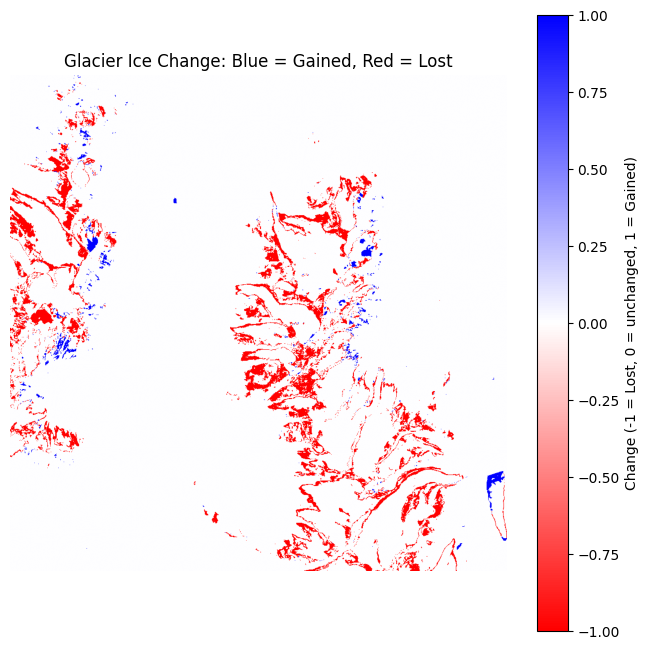

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the first snow/ice mask from .npy file (e.g., from 2000)
mask1 = np.load("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region_mask_2017.npy")

# Load the second snow/ice mask from .npy file (e.g., from 2020)
mask2 = np.load("/content/drive/MyDrive/GEOL0069_data/Final Project/CNN_deployment_region_mask_2023.npy")

# Ensure both masks are binary (1 = snow/ice, 0 = no snow/ice)
mask1 = (mask1 > 0).astype(int)
mask2 = (mask2 > 0).astype(int)

# Compare masks: 1 = snow/ice gained, -1 = snow/ice lost, 0 = unchanged
difference = mask2 - mask1

# Calculate statistics
total_pixels = mask1.size
ice_gained = np.sum(difference == 1)
ice_lost = np.sum(difference == -1)
unchanged = np.sum(difference == 0)

print(f"Glacier Ice gained: {ice_gained / total_pixels * 100:.2f}%")
print(f"Glacier Ice lost: {ice_lost / total_pixels * 100:.2f}%")
print(f"Unchanged: {unchanged / total_pixels * 100:.2f}%")

# Calculate total pixels that were ice in the first mask
initial_ice_pixels = np.sum(mask1 == 1)

# Calculate how many of those were lost (i.e., changed from 1 to 0)
ice_lost_from_initial = np.sum((mask1 == 1) & (mask2 == 0))

# Percentage of initial ice that has been lost
percent_ice_lost_from_initial = (ice_lost_from_initial / initial_ice_pixels) * 100

print(f"Glacier Ice lost relative to initial ice cover: {percent_ice_lost_from_initial:.2f}%")


# Visualize the difference
plt.figure(figsize=(8, 8))
plt.imshow(difference, cmap='bwr_r', vmin=-1, vmax=1)
plt.title("Glacier Ice Change: Blue = Gained, Red = Lost")
plt.colorbar(label="Change (-1 = Lost, 0 = unchanged, 1 = Gained)")
plt.axis("off")
plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/Glacier_retreat.png", dpi=300, bbox_inches='tight')
plt.show()


The code cell below uses the data from the figure above to calculate the projected loss of ice in the region, assuming exponential loss.

Ice remaining in 2030: 51.18%
Ice remaining in 2050: 18.27%


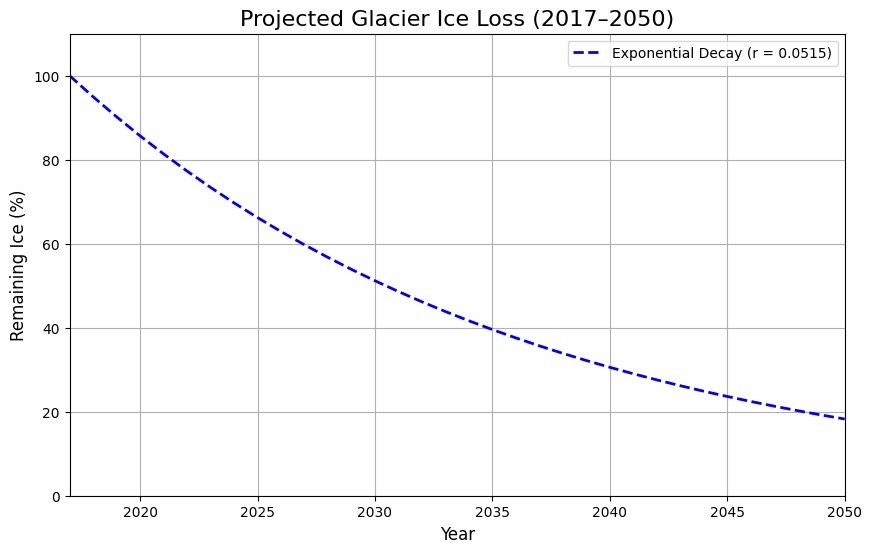

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
initial_ice = 100  # Initial ice cover in 2017
ice_2023 = 73.41  # Ice cover in 2023 (%)
t0 = 2017
t_target = 2023
years = np.arange(t0, 2051)

# Calculate decay rate from 2017 to 2023
r = -np.log(ice_2023 / initial_ice) / (t_target - t0)

# Exponential decay model: A(t) = A0 * exp(-r * (t - t0))
def exponential_decay(t, A0, r, t0):
    return A0 * np.exp(-r * (t - t0))

# Compute ice loss
exp_ice_remaining = exponential_decay(years, initial_ice, r, t0)

# Print remaining ice in 2030 and 2050
ice_2030 = exp_ice_remaining[years == 2030][0]
ice_2050 = exp_ice_remaining[years == 2050][0]
print(f"Ice remaining in 2030: {ice_2030:.2f}%")
print(f"Ice remaining in 2050: {ice_2050:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, exp_ice_remaining, label=f"Exponential Decay (r = {r:.4f})", color="blue", linestyle="--", linewidth=2)

# Labels and title
plt.title("Projected Glacier Ice Loss (2017–2050)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Remaining Ice (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.xlim(2017, 2050)
plt.ylim(0, 110)
plt.savefig("/content/drive/MyDrive/GEOL0069_data/Final Project/Projected_ice_loss.png", dpi=300, bbox_inches='tight')
plt.show()



#Enviromental cost

In [ ]:
pip install carbontracker

In [ ]:
import rasterio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from carbontracker.tracker import CarbonTracker

#Set up emissions tracker
tracker = CarbonTracker(epochs=10, monitor_epochs=1, verbose=1)

# file paths
band_nir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B8A_20m.jp2"
band_green_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B03_20m.jp2"
band_swir_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B11_20m.jp2"
band_red_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B04_20m.jp2"
band_blue_path = "/content/drive/MyDrive/GEOL0069_data/Final Project/S2A_MSIL2A_20170815T102021_N0500_R065_T32TMS_20231005T191904.SAFE/GRANULE/L2A_T32TMS_A011216_20170815T102513/IMG_DATA/R20m/T32TMS_20170815T102021_B02_20m.jp2"

# Test region
test_region = {"col_off": 1000, "row_off": 2000, "width": 1000, "height": 1000}
window_20m = rasterio.windows.Window(**test_region)

# Read 20m bands
def read_band(path, window):
    with rasterio.open(path) as src:
        return src.read(1, window=window).astype(np.float32)

# Normalize
def normalize_band(band):
    return band / np.max(band)

# Read and normalize all bands (all are 20m resolution now)
green_band = normalize_band(read_band(band_green_path, window_20m))
swir_band  = normalize_band(read_band(band_swir_path,  window_20m))
red_band   = normalize_band(read_band(band_red_path,   window_20m))
blue_band  = normalize_band(read_band(band_blue_path,  window_20m))
nir_band   = normalize_band(read_band(band_nir_path,   window_20m))  # Using B8A directly

# Stack all bands into (H, W, 5)
data = np.stack((green_band, swir_band, red_band, blue_band, nir_band), axis=-1)

# Load mask
mask_path = '/content/drive/MyDrive/GEOL0069_data/Final Project/Test_Region_glacier_mask.npy'
mask_snow = np.load(mask_path)

# Flatten data and labels
X = data.reshape(-1, 5)
y = mask_snow.reshape(-1).astype(np.uint8)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input
X_train = X_train.reshape(-1, 1, 1, 5)
X_val = X_val.reshape(-1, 1, 1, 5)

# One-hot encode
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

# Define CNN
model = models.Sequential([
    layers.Input(shape=(1, 1, 5)),
    layers.Conv2D(16, (1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

for epoch in range(10):
    tracker.epoch_start()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=256,
        verbose=1
    )

    tracker.epoch_end()

tracker.stop()


CarbonTracker: INFO - Detected CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
CarbonTracker: WARNING - No matching TDP found for CPU: Intel(R) Xeon(R) CPU @ 2.20GHz. Using average TDP of 35.61W as fallback.
CarbonTracker: The following components were found: CPU with device(s) Intel(R) Xeon(R) CPU @ 2.20GHz.
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 369.47318 gCO2/kWh.
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9640 - loss: 0.1478 - val_accuracy: 0.9964 - val_loss: 0.0119
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 369.47318 gCO2/kWh.
CarbonTracker: Live carbon intensity could not be fetched at detected location: Washington, District of Columbia, US. Defaulted to average 